In [1]:
import word2vecmodel
import preprocess
import engine
import visualize
import pandas as pd

## 학습 및 모델 저장

In [2]:
trainloader, dataset = preprocess.getTrainLoader()

In [ ]:
engine.train(trainloader)
engine.save("/content/save")

## 태그 임베딩 모델 불러오기

In [5]:
enc = engine.load("/content/save")

## 적합도 비교

In [6]:
jobkeywordlist = preprocess.getJobList()
top_k = 30

In [8]:
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

def get_cosim(tag1, tag2):
    tag1 = tag1.reshape(1, -1)
    tag2 = tag2.reshape(1, -1)

    return cosine_similarity(tag1, tag2)


def cal_score(user_taglist):
    jobidlist = preprocess.getJobList().ID.tolist()
    job_scores = []
    for jobid in jobidlist:  # job 하나
        job_taglist = jobkeywordlist[jobkeywordlist['ID'] == jobid]['tags'].tolist()[0]
        tag_scores = dict()

        for job_tag in job_taglist:  # job의 tag 하나
            embedded_jobtag = engine.tagembedding(job_tag)

            for user_tag in user_taglist:  # user의 tag 하나
                embedded_usertag = engine.tagembedding(user_tag)
                cosim = get_cosim(embedded_jobtag, embedded_usertag)
                score = 0
                if cosim >= 0.999999: # HTML 같은 경우에 유사도가 0.999999 나옴
                    score = 1
                elif cosim > 0.9:
                    score = 0.7

                if score > 0:
                    if job_tag in tag_scores:
                        tag_scores[job_tag] = max(score, tag_scores[job_tag])
                    else:
                        tag_scores[job_tag] = score
                    if score == 1:
                        break

        sum_scores = 0
        for k, v in tag_scores.items():
            sum_scores += v

        job_scores.append(sum_scores / len(job_taglist))

    job_score_pd = pd.DataFrame({'jobID': jobidlist,
                                 'tags': jobkeywordlist["tags"].tolist(),
                                 'score': job_scores})

    job_score_pd = job_score_pd.sort_values(by=['score'], axis=0, ascending=False)
    job_score_pd.reset_index(drop=True, inplace=True)
    return job_score_pd[:top_k]

##태그 유사도 시각화

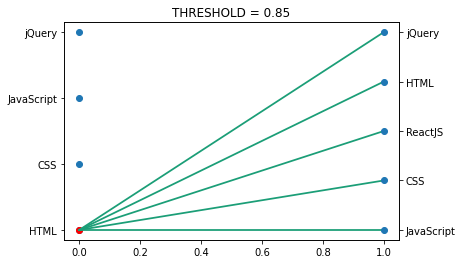

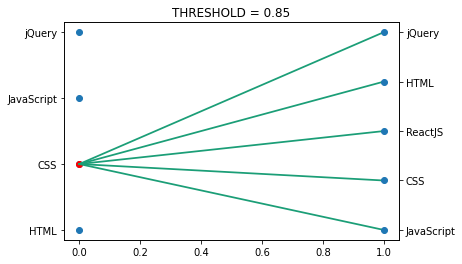

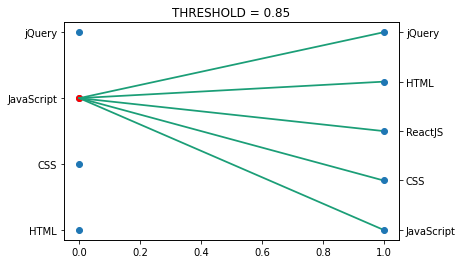

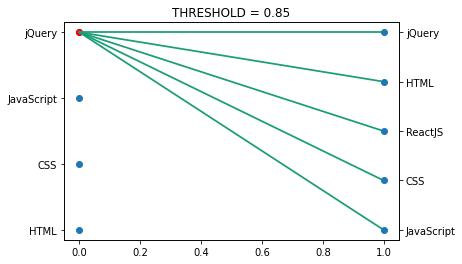

In [9]:
list1 = ['HTML', 'CSS', "JavaScript", 'jQuery']
list2 = ['JavaScript', 'CSS', 'ReactJS', 'HTML', 'jQuery']	
visualize.visualize_eachtagbyTagList(list1, list2, config)

## 테스트

In [10]:
cal_score(['HTML', 'CSS', "JavaScript", 'jQuery'])

,jobID,tags,score
0,5a4b25aaed25c2ee1b74de72dc03c14e,"[CSS, HTML, jQuery, JavaScript]",1.000
1,84d2004bf28a2095230e8e14993d398d,"[JavaScript, CSS, HTML]",1.000
2,63538fe6ef330c13a05a3ed7e599d5f7,"[CSS, JavaScript, HTML]",1.000
3,fb89705ae6d743bf1e848c206e16a1d7,"[JavaScript, HTML, CSS]",1.000
4,c042f4db68f23406c6cecf84a7ebb0fe,"[HTML, CSS, JavaScript]",1.000
5,41f1f19176d383480afa65d325c06ed0,[JavaScript],1.000
6,dc912a253d1e9ba40e2c597ed2376640,"[CSS, JavaScript, HTML]",1.000
7,2b6d65b9a9445c4271ab9076ead5605a,"[JavaScript, CSS, HTML]",1.000
8,286674e3082feb7e5afb92777e48821f,"[HTML, JavaScript, CSS]",1.000
9,995665640dc319973d3173a74a03860c,"[JavaScript, CSS, HTML]",1.000


## 테스트 with GUI

In [11]:
import ipywidgets as widgets

desc = widgets.Label(value='기술 스택 (쉼표로 구분)')
tags_input = widgets.Text(
    value='',
    placeholder='예: HTML, CSS, JavaScript',
    description='',
    disabled=False,
    layout=widgets.Layout(width='50%')
)
search_button = widgets.Button(
    description='검색',
    layout=widgets.Layout(width='10%'))
input_with_button = widgets.HBox([tags_input, search_button])
output_html = widgets.HTML(
    value=""
)
display(widgets.VBox([desc, input_with_button, output_html]))

def search(b):
    tags_input_ed = [x.strip() for x in tags_input.value.split(',')]
    styles = [
        {'selector':'td', 'props':[('padding', '10px'), ('vertical-align', 'top'), ('border-bottom', '1px solid #ccc'), ('background', '#eee')
         ]}, 
        {'selector':'th', 'props':[('padding', '10px'), ('font-weight', 'bold'), ('vertical-align', 'top'), ('color', '#fff'), ('background', '#ce4869')]}
    ]
    output_html.value = cal_score(tags_input_ed).style.set_table_styles(styles).render()
    # print(cal_score(tags_input_ed).to_html(notebook=True))

search_button.on_click(search)